# Running oxDNA Analyses using OAT 

The oxDNA analysis tools have been bundled up into a Python library so I want to get the hang of using them as Python functions instead of making calls to the command line. The tools I want to use are:

* plot energy -- done
* RMSF analysis -- done
* bond analysis -- not working
* PCA -- done
* clustering -- done

In [4]:
from oxDNA_analysis_tools.bond_analysis import bond_analysis
from oxDNA_analysis_tools.mean import mean
from oxDNA_analysis_tools.deviations import deviations
from oxDNA_analysis_tools.deviations import output
from oxDNA_analysis_tools.pca import pca

# all functions required to read a configuration using the new RyeReader
from oxDNA_analysis_tools.UTILS.RyeReader import describe, get_confs, inbox

# the function used to visualize a configuration in oxView
from oxDNA_analysis_tools.UTILS.oxview import oxdna_conf

import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
mydir = "/home/emma/Documents/research/gnn-dna/dsdna-dataset/t1"
top = os.path.join(mydir, "sim_out/top.top") 
traj = os.path.join(mydir, "sim_out/trajectory_sim.dat")
input_file = "/home/emma/repos/gnn-dna-sim/src/dataset-generation/dsDNA/input_sim"

# RyeReader uses indexing allows for random access in the trajectory
top_info, traj_info = describe(top, traj)
print(top_info)

TopInfo(path='/home/emma/Documents/research/gnn-dna/dsdna-dataset/t1/sim_out/top.top', nbases=40)


## Energy Plot


In [ ]:
# read in first and last columns
energy_file = "/home/emma/Documents/research/gnn-dna/dsdna-dataset/t1/sim_out/energy_sim.dat"

data = np.genfromtxt(energy_file,
                 delimiter='  ')

# convert first column to time
dt = 0.005 # assuming this will be true for all simulations
time = data[:,0] * dt * 3.03 # 3.03 ps = 1 unit of time in oxdna

# convert last column to energy
total_energy = data[:,3] * 4.142 # e-20 J

# plot data
plt.figure()
plt.plot(time, total_energy)
plt.xlabel("Time [ps]")
plt.ylabel("Energy [e-20 J]")
# plt.savefig("{}/energy.png".format(output_dir))

## RMSD / RMSF Analysis

INFO: Processing in blocks of 20 configurations
INFO: You can modify this number by running oat config -n <number>, which will be persistent between analyses.


Starting up 4 processes for 50 chunks
All spawned, waiting for results


INFO: Processing in blocks of 20 configurations
INFO: You can modify this number by running oat config -n <number>, which will be persistent between analyses.


Starting up 4 processes for 50 chunks
All spawned, waiting for results
INFO: writing RMSDs to oxView order parameter file, /home/emma/Documents/research/gnn-dna/dsdna-dataset/t1/sim_out/rmsd_op.json
INFO: writing RMSD plot to /home/emma/Documents/research/gnn-dna/dsdna-dataset/t1/sim_out/rmsd.png


INFO: writing deviations to /home/emma/Documents/research/gnn-dna/dsdna-dataset/t1/sim_out/devs.json


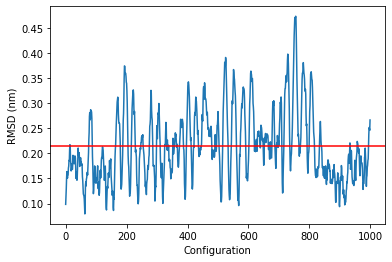

In [5]:
# Compute the mean structure and RMSFs
mean_conf = mean(traj_info, top_info, ncpus=4)
RMSDs, RMSFs = deviations(traj_info, top_info, mean_conf, ncpus=4)
outfile = os.path.join(mydir, "sim_out/devs.json")
rmsd_plot_name = os.path.join(mydir, "sim_out/rmsd.png")
rmsd_data_file = os.path.join(mydir, "sim_out/rmsd_op.json")
output(RMSDs, RMSFs, outfile, rmsd_plot_name, rmsd_data_file)

#They come out as numpy arrays, need to be a dict with a list for visualization
RMSFs = {"RMSF": RMSFs.tolist()}

In [ ]:
# Display python objects in an oxview iframe
oxdna_conf(top_info, mean_conf, RMSFs)

## Bond Analysis

Currently not working - seems to be hanging up while running a multi-threaded process of reading the configurations.

In [ ]:
!pwd
# !oat generate_force -o ./forces.txt -f ./pairs.txt input_sim conf.dat # don't use this

# forces2pairs -o <output_file> <force file>
# !oat forces2pairs -o pairs.txt external_forces.txt

# bond_analysis (-p <n_cpus>) <input> <trajectory> <designed_pairs_file> <output_file>
# !oat bond_analysis -p 4 /home/emma/Documents/research/gnn-dna/dsdna-dataset/t1/input_sim traj_info 
!oat bond_analysis /home/emma/Documents/research/gnn-dna/dsdna-dataset/t1/input_sim /home/emma/Documents/research/gnn-dna/dsdna-dataset/t1/sim_out/trajectory_sim.dat /home/emma/Documents/research/gnn-dna/dsdna-dataset/t1/pairs.txt /home/emma/Documents/research/gnn-dna/dsdna-dataset/t1/sim_out/bonds.json

In [ ]:
bond_analysis(traj_info, top_info, pairs="/home/emma/Documents/research/gnn-dna/dsdna-dataset/t1/pairs.txt", inputfile="/home/emma/Documents/research/gnn-dna/dsdna-dataset/t1/input_sim", ncpus=4)

## PCA Analysis

There is a scripted version of the PCA analysis but I don't know what to do with the outputs, which are numpy arrays.

Instead we can use the CLI version. In this case we need to get the mean configuration first as shown below. 

The PCA tool returns:

* coordinates2.png
* scree.png
* pca0.json (these are the arrow overlays you can use on your oxView visualization. There may be more than one set of principal components, and you may find that the arrows are small)

In [22]:
# structure, eigenvalues, eigenvectors = pca(traj_info, top_info, mean_conf, ncpus=4)

In [13]:
!oat mean -h

usage: mean.py [-h] [-p num_cpus] [-o output_file] [-d deviation_file]
               [-i index_file] [-a alignment_configuration]
               trajectory

Computes the mean structure of a trajectory file

positional arguments:
  trajectory            The trajectory file you wish to analyze

optional arguments:
  -h, --help            show this help message and exit
  -p num_cpus           (optional) How many cores to use
  -o output_file, --output output_file
                        The filename to save the mean structure to
  -d deviation_file, --deviations deviation_file
                        Immediatley run oat deviations from the output
  -i index_file         Compute mean structure of a subset of particles from a
                        space-separated list in the provided file
  -a alignment_configuration, --align alignment_configuration
                        The id of the configuration to align to, otherwise
                        random


In [14]:
!oat mean -p 4 -o /home/emma/Documents/research/gnn-dna/dsdna-dataset/t1/sim_out/mean.dat /home/emma/Documents/research/gnn-dna/dsdna-dataset/t1/sim_out/trajectory_sim.dat 

INFO: oxDNA_analysis_tools version: 2.0.3
INFO: running config.py installed at:  /home/emma/miniconda3/envs/oxdna/lib/python3.9/site-packages/oxDNA_analysis_tools/config.py
INFO: Python version: 3.9.12
INFO: Package Numpy found. Version: 1.23.1
INFO: No dependency issues found.
INFO: Processing in blocks of 20 configurations
INFO: You can modify this number by running oat config -n <number>, which will be persistent between analyses.
Starting up 4 processes for 50 chunks
All spawned, waiting for results
--- 0.14360833168029785 seconds ---


In [23]:
!oat pca -p 4 /home/emma/Documents/research/gnn-dna/dsdna-dataset/t1/sim_out/trajectory_sim.dat /home/emma/Documents/research/gnn-dna/dsdna-dataset/t1/sim_out/mean.dat /home/emma/Documents/research/gnn-dna/dsdna-dataset/t1/sim_out/pca.json

INFO: oxDNA_analysis_tools version: 2.0.3
INFO: running config.py installed at:  /home/emma/miniconda3/envs/oxdna/lib/python3.9/site-packages/oxDNA_analysis_tools/config.py
INFO: Python version: 3.9.12
INFO: Package Numpy found. Version: 1.23.1
INFO: No dependency issues found.
INFO: Processing in blocks of 20 configurations
INFO: You can modify this number by running oat config -n <number>, which will be persistent between analyses.
Starting up 4 processes for 50 chunks
All spawned, waiting for results
INFO: calculating eigenvectors
INFO: eigenvectors calculated
INFO: Saving scree plot to scree.png
/home/emma/miniconda3/envs/oxdna/lib/python3.9/site-packages/matplotlib/collections.py:196: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
90% of the variance is found in the first 10 components
INFO: Processing in blocks of 20 configurations
INFO: You can modify this number by running oat config -n <number>, which will b

## Clustering

Clustering can be run on its own but you can also call it from the PCA command. The outputs are:

* cluster_data.json (which is also the serialized_data input as shown below)
* cluster_0.dat (this is the configuration of the first cluster, there may be more than 1)
* centroid_0.dat
* animated.mp4

In [20]:
!oat clustering -h

usage: clustering.py [-h] [-e EPS] [-m MIN_SAMPLES] serialized_data

Calculates clusters based on provided order parameters.

positional arguments:
  serialized_data       The json-formatted input file

optional arguments:
  -h, --help            show this help message and exit
  -e EPS, --eps EPS     The epsilon parameter for DBSCAN (maximum distance to
                        be considered a 'neighbor')
  -m MIN_SAMPLES, --min_samples MIN_SAMPLES
                        The min_samples parameter for DBSCAN (number of
                        neighbors which define a point as a central point in a
                        cluster)


In [21]:
!oat clustering /home/emma/Documents/research/gnn-dna/dsdna-dataset/t1/sim_out/cluster_data.json

INFO: oxDNA_analysis_tools version: 2.0.3
INFO: running config.py installed at:  /home/emma/miniconda3/envs/oxdna/lib/python3.9/site-packages/oxDNA_analysis_tools/config.py
INFO: Python version: 3.9.12
INFO: Package SciKit-Learn found. Version: 1.1.2
INFO: Package MatPlotLib found. Version: 3.5.3
INFO: No dependency issues found.
INFO: Serializing input data to cluster_data.json
INFO: Run  `oat clustering cluster_data.json -e<eps> -m<min_samples>`  to adjust clustering parameters
INFO: Running DBSCAN...
INFO: Current values: eps=12, min_samples=8
Number of clusters: 1
cluster	members
0	1000
INFO: splitting trajectory...
INFO: Trajectories for each cluster will be written to cluster_<cluster number>.dat
INFO: Wrote trajectory files: ['cluster_0.dat']
INFO: Finding cluster centroid...
INFO: Wrote centroid file centroid_0.dat
INFO: Making cluster plot...
INFO: Saved cluster plot to animated.mp4
INFO: Run  `oat clustering cluster_data.json -e<eps> -m<min_samples>`  to adjust clustering par